# Stochastic Simulation Assignment 1

## Computing the Area of the Mandelbrot Set
_Authors: Sai Vinay Vardhan Daliparthi (15073815), Boyan Mihaylov (15067602), Nitai Nijholt (12709018)_

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


## Mandelbrot Simulation

The following functions compute the Mandelbrot set by iterating a regular rectangular grid of complex numbers through a recursive function.

In [76]:
def Mandelbrot(c, max_iter, threshold = 2):
    '''Simulates the Mandlebrot set, given the maximum number of iterations, the threshold value of z, and the starting value of c.
    based on formula's found on https://en.wikipedia.org/wiki/Mandelbrot_set
    A number is part of the Mandlebrot set if the absolute value of z is smaller than threshold after a certain number of iterations are performed.
    The threshold is 2 by conventioon, but can be changed.'''
    z = c
    for n in range(max_iter):
        if abs(z) > threshold:
            return n, z
        z = z**2 + c
    return max_iter, z

In [59]:
def calculate_mandelbrot(xmin,xmax,ymin,ymax,wsteps,hsteps,max_iter, threshold):
    '''Generates point sample grid for the iteration function and passes it to the Mandelbrot function.
    Returns the initial point positions and the iterations until divergence above the threshold.'''
    r1 = np.linspace(xmin, xmax, wsteps)
    r2 = np.linspace(ymin, ymax, hsteps)
    n3 = np.empty((wsteps, hsteps))
    for i in range(wsteps):
        for j in range(hsteps):
            imaginary_component = 1j
            n3[i,j], _ = Mandelbrot(r1[i] + imaginary_component*r2[j],max_iter, threshold)
    return (r1,r2,n3.T)

## Approximating the Area

For a dense rectangular grid of points it is assumed that the area around the point can be calculated as:

$$
A_{pt}=\frac{1}{n_x n_y}A_R
$$

where $A_R$ is the area of the bounding region ($A_R=w\times h$) and $n_x$ and $n_y$ are the number of grid cells in $x$ and $y$ direction, respectively.

Then, to calculate the area $A_M$ of the Mandelbrot set we count the points which do not escape under the iteration function ($N_M$) and approximate the area as:

$$
A_M = N_M A_R
$$

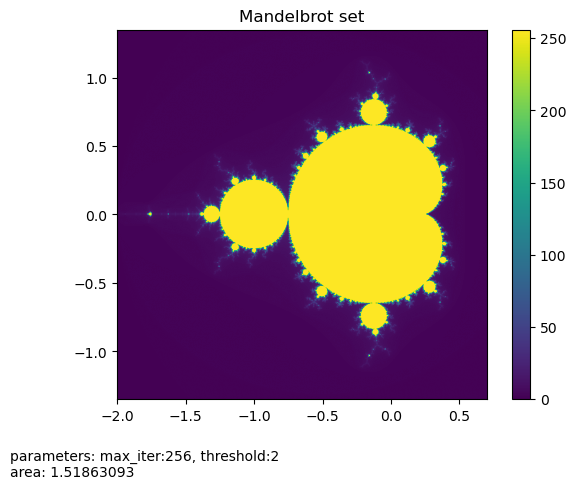

In [60]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
wsteps, hsteps = 1000, 1000

# parameters
max_iter = 256
threshold = 2

x,y,z = calculate_mandelbrot(xmin,xmax,ymin,ymax,wsteps,hsteps,max_iter,threshold=2)

# Calculate area
pt_area = (xmax - xmin) * (ymax - ymin) / (wsteps * hsteps)
area = np.sum(np.where(z == np.max(z), 1, 0)) * pt_area

plt.imshow(z, extent=(xmin, xmax, ymin, ymax))
plt.title("Mandelbrot set")
plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}\narea: {area}', horizontalalignment='left')
plt.colorbar()
plt.show()

## Stochastic Sampling of the Mandelbrot set

The following function is a variation of the Mandelbrot iterator, this time iterating randomly sampled points instead of a regular grid.

In [5]:
# def Monte_carlo_mandelbrot(func, s, boundry)
#     points_in_mandelbrot = []
#     generated_points = np.random.uniform(0,1000, (s, 2))
#     for point in generated_points:
#         if func(point) >= boundry:
#             points_in_mandelbrot.append(func(point))


In [61]:
def calculate_mandelbrot_stochastic(xmin,xmax,ymin,ymax,n_samples,max_iter, threshold):
    '''Generates random point samples for the iteration function and passes it to the Mandelbrot function.
    Returns the initial point positions and the iterations until divergence above the threshold.'''
    c_samples = np.random.uniform((xmin, ymin), (xmax, ymax), (n_samples, 2))
    n3 = np.empty(n_samples)
    z_last = np.empty(n_samples, dtype=np.csingle)
    for i in range(n_samples):
        imaginary_component = 1j
        c = c_samples[i]
        n3[i], z_last[i] = Mandelbrot(c[0] + imaginary_component*c[1], max_iter, threshold)
    return (c_samples, n3, z_last)

The procedure below executes the stochastic Mandelbrot iteration and plots the following results:
- a scatterplot of the initial sampling of the space with a colour assigned to each sample depending on the number of iterations before their divergence;
- a scatterplot of the iterated positions of the samples, colours analogous to the above.

The purpose of the second plot is to observe the change in distribution of the samples after iteration, exploring the possibilities for resampling specific regions during the iteration process.

(20000, 2)
(20000,)


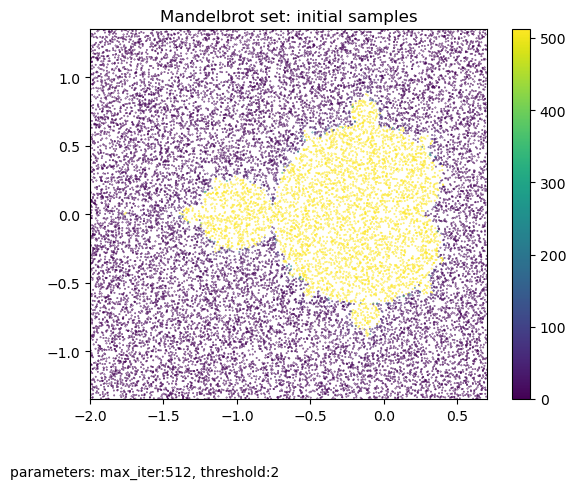

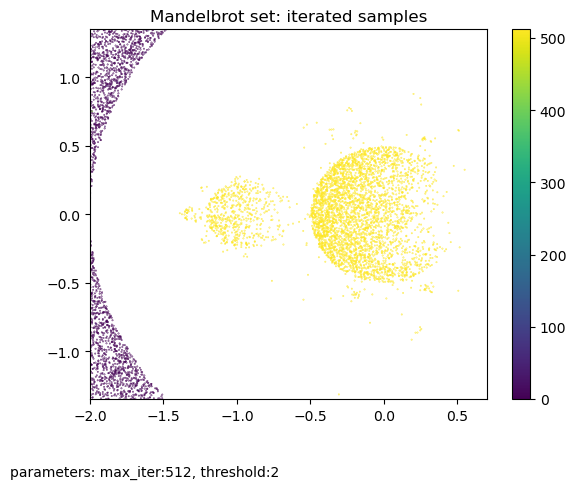

In [77]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
n_samples = 20000

# parameters
max_iter = 512
threshold = 2

pts, iter, z_last = calculate_mandelbrot_stochastic(xmin,xmax,ymin,ymax,n_samples,max_iter,threshold=2)

plt.scatter(pts.T[0], pts.T[1], c=iter, s=0.1)
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))
plt.title("Mandelbrot set: initial samples")
plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}', horizontalalignment='left')
plt.colorbar()
plt.show()

plt.scatter(z_last.real, z_last.imag, c=iter, s=0.1)
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))
plt.title("Mandelbrot set: iterated samples")
plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}', horizontalalignment='left')
plt.colorbar()
plt.show()